In [1]:
import numpy as np
import ee
import folium
import pandas as pd
from scipy.interpolate import griddata

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.preprocessing import StandardScaler

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

from matplotlib import pyplot as plt
import seaborn as sns

In [54]:
from pykrige.ok import OrdinaryKriging

In [2]:
import tqdm

In [3]:
#!earthengine authenticate
ee.Initialize()

In [4]:
def foliumLayer(image,parameters,layer_name = "layer"):
    
    folium_map = folium.Map(location = [centery,centerx],zoom_start = 13,tiles = 'openstreetmap')
    
    mapIdDict = image.getMapId(parameters) # convertir imagen a id de visualizacion
    
    tile = folium.TileLayer(tiles = mapIdDict['tile_fetcher'].url_format,
                            attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
                            overlay = True,
                            name = layer_name)
    
    tile.add_to(folium_map)
    
    folium_map.add_child(folium.LayerControl())
    
    return folium_map

In [5]:
def getLatLonPixels(mask,ROI,scale = 10):
    
    t = tqdm.tqdm(total = 4)
    t.update(n=0)
    t.set_description(desc = "Creating LonLat image", refresh=True)
    
    lonlat = mask.pixelLonLat().multiply(mask)
    
    t.update(n=1)
    t.set_description(desc = "Creating dictionary", refresh=True)
    
    dic = lonlat.reduceRegion(reducer = ee.Reducer.toList(),geometry = ROI,scale = scale).getInfo()
    
    lat = dic['latitude']
    lon = dic['longitude']
    
    t.update(n=2)
    t.set_description(desc = "Creating array | Deleting duplicates", refresh=True)
    
    coords = np.array([lon,lat]).T
    coords = np.unique(coords,axis = 0)
    coords = coords[:len(coords)-1]
    
    t.update(n=3)
    t.set_description(desc = "Done", refresh=True)
    t.close()
    
    return coords

In [6]:
def loadBathymetry(filePath,delimeter = "\t",usecols = (2,3,5),startLine = 7):

    f = open(filePath)
    textList = f.readlines()[startLine:]

    outF = open("bathyTemp.txt","w")
    for line in textList:
        line = line.replace(",",".")
        outF.write(line)    
    outF.close()

    bathy = np.loadtxt("bathyTemp.txt",delimiter = delimeter,usecols = usecols)    
    
    return bathy

# Alto-Lindoso

In [7]:
xmin = -8.2260339
ymin = 41.8596283
xmax = -8.0632989
ymax = 41.9309290

centerx = np.array([xmin,xmax]).mean()
centery = np.array([ymin,ymax]).mean()

ROI = ee.Geometry.Rectangle([xmin,ymin,xmax,ymax])

In [8]:
wmp = ee.Image('users/dmlmont/TFM/WMp_Alto_Lindoso')
img = ee.Image('users/dmlmont/TFM/Pre_Alto_Lindoso')

In [9]:
coords = getLatLonPixels(wmp,ROI)

Done: : 6it [00:05,  1.17it/s]                                                                                         


(-8.234595170781745, -8.05472712532513, 41.84622383645203, 41.94461477604277)

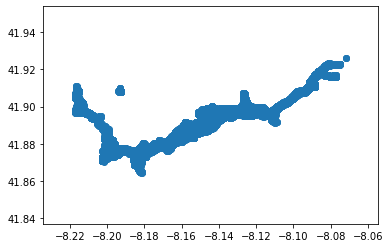

In [10]:
plt.scatter(coords[:,0],coords[:,1])
plt.axis('equal')

In [11]:
bathy = loadBathymetry("C:/Users/Dave Mont/Desktop/Master_of_DataScience/TFM/Bat_data/bathymetric_data_alto_lindoso")

In [26]:
X = bathy[:,0:2]
y = bathy[:,2]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

In [27]:
y_pred = griddata(X_train,y_train,X_test,method = 'cubic')

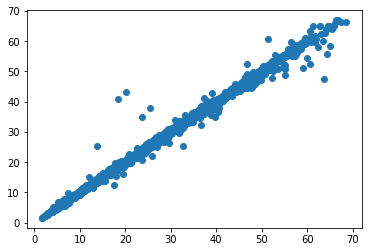

In [28]:
plt.scatter(y_pred,y_test)

In [15]:
depth = griddata(X,y,coords,method = 'cubic',fill_value = 0)

In [36]:
depthdf = pd.DataFrame(np.column_stack((coords,depth)))

In [38]:
depthdf.columns = ['Lon','Lat','Depth']

In [51]:
depthdf.to_csv('C:/Users/Dave Mont/Desktop/Master_of_DataScience/TFM/Results/depth_estimation/AL_depth_cubic.csv',index = False)

In [19]:
OK = OrdinaryKriging(X_train[:,0],X_train[:,1],y_train,variogram_model = 'gaussian')

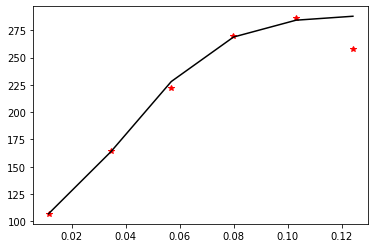

In [25]:
OK.display_variogram_model()

In [20]:
y_pred,ss = OK.execute('points',X_test[:,0],X_test[:,1])

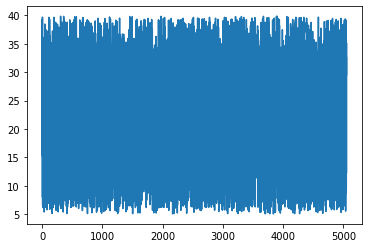

In [22]:
plt.plot(y_pred)

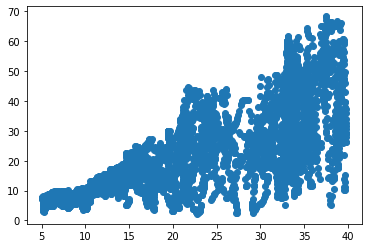

In [23]:
plt.scatter(y_pred,y_test)

In [55]:
OK_complete = OrdinaryKriging(X[:,0],X[:,1],y,variogram_model = 'gaussian')

In [ ]:
OK_complete

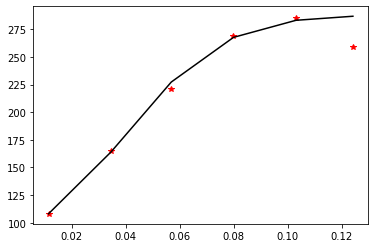

In [60]:
OK_complete.display_variogram_model()

In [ ]:
depth_ok,ss_ok = OK_complete.execute('points',coords[0,0],coords[0,1])

In [52]:
features = []
for i in range(len(X)):
    point = ee.Geometry.Point([X[i,0],X[i,1]])
    features.append(ee.Feature(point,{'depth':y[i]}))
featureCollection = ee.FeatureCollection(features)

In [ ]:
featureCollection.kriging()

In [122]:
features = []
for i in range(5000):
    point = ee.Geometry.Point([coords[i,0],coords[i,1]])
    features.append(ee.Feature(point,{'depth':depth[i]}))
featureCollection = ee.FeatureCollection(features)

In [84]:
depthImage = wmp.toFloat().paint(featureCollection,'depth')

In [123]:
depthImage = wmp.multiply(featureCollection.reduceToImage(['depth'],ee.Reducer.first()))

In [126]:
foliumLayer(depthImage,{"min":0,"max":100,'palette':['FF3333','FFFF33','33FFF6']},"depth")

# Bubal

In [12]:
xmin = -0.3245736
ymin = 42.6798840
xmax = -0.2969361
ymax = 42.7209728

centerx = np.array([xmin,xmax]).mean()
centery = np.array([ymin,ymax]).mean()

ROI = ee.Geometry.Rectangle([xmin,ymin,xmax,ymax])

In [13]:
wmp = ee.Image('users/dmlmont/TFM/WMp_Bubal')

In [14]:
coords = getLatLonPixels(wmp,ROI)

Done: : 6it [00:01,  4.76it/s]                                                                                         


(-0.3295193570222865,
 -0.29401183609845255,
 42.66436025136522,
 42.72644053205303)

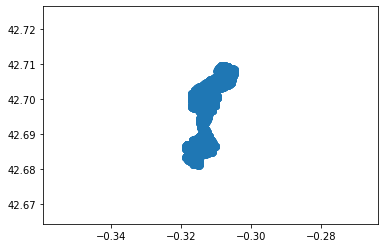

In [15]:
plt.scatter(coords[:,1],coords[:,0])
plt.axis('equal')

In [16]:
coords.shape

(12848, 2)

# Canelles

In [17]:
xmin = 0.5664387
ymin = 41.9718079
xmax = 0.7096043
ymax = 42.1213370

centerx = np.array([xmin,xmax]).mean()
centery = np.array([ymin,ymax]).mean()

ROI = ee.Geometry.Rectangle([xmin,ymin,xmax,ymax])

In [18]:
wmp = ee.Image('users/dmlmont/TFM/WMp_Canelles')

In [19]:
coords = getLatLonPixels(wmp,ROI)

Done: : 6it [00:11,  1.99s/it]                                                                                         


(0.5519362731347142, 0.7191798538944087, 41.95064148504942, 42.13148944548096)

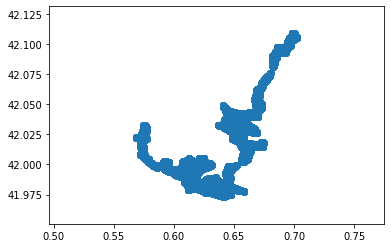

In [20]:
plt.scatter(coords[:,1],coords[:,0])
plt.axis('equal')

In [21]:
coords.shape

(177383, 2)

# Grado

In [23]:
xmin = 0.1912200
ymin = 42.1501858
xmax = 0.2537043
ymax = 42.3090388

centerx = np.array([xmin,xmax]).mean()
centery = np.array([ymin,ymax]).mean()

ROI = ee.Geometry.Rectangle([xmin,ymin,xmax,ymax])

In [24]:
wmp = ee.Image('users/dmlmont/TFM/WMp_Grado')

In [25]:
coords = getLatLonPixels(wmp,ROI)

Done: : 6it [00:05,  1.01it/s]                                                                                         


(0.19835039415242925,
 0.25314286764604216,
 42.12780273380704,
 42.33206977369558)

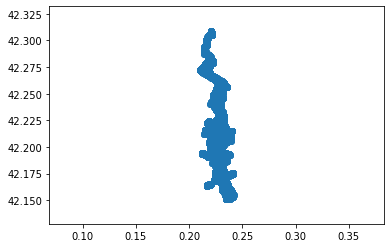

In [26]:
plt.scatter(coords[:,1],coords[:,0])
plt.axis('equal')

In [27]:
coords.shape

(123454, 2)

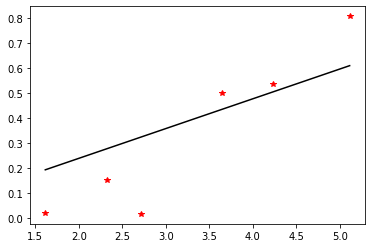

In [1]:
import numpy as np
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

data = np.array([[0.3, 1.2, 0.47],
                 [1.9, 0.6, 0.56],
                 [1.1, 3.2, 0.74],
                 [3.3, 4.4, 1.47],
                 [4.7, 3.8, 1.74]])

gridx = np.arange(0.0, 5.5, 0.5)
gridy = np.arange(0.0, 5.5, 0.5)

# Create the ordinary kriging object. Required inputs are the X-coordinates of
# the data points, the Y-coordinates of the data points, and the Z-values of the
# data points. If no variogram model is specified, defaults to a linear variogram
# model. If no variogram model parameters are specified, then the code automatically
# calculates the parameters by fitting the variogram model to the binned
# experimental semivariogram. The verbose kwarg controls code talk-back, and
# the enable_plotting kwarg controls the display of the semivariogram.
OK = OrdinaryKriging(data[:, 0], data[:, 1], data[:, 2], variogram_model='linear',
                     verbose=False, enable_plotting=True)

# Creates the kriged grid and the variance grid. Allows for kriging on a rectangular
# grid of points, on a masked rectangular grid of points, or with arbitrary points.
# (See OrdinaryKriging.__doc__ for more information.)
z, ss = OK.execute('grid', gridx, gridy)

In [3]:
ss

masked_array(
  data=[[0.2592348462151437, 0.21697173215927967, 0.185620050093106,
         0.1507003616085125, 0.14098079771101837, 0.1934962343941475,
         0.27091057749162145, 0.3485939641380801, 0.42182740911446853,
         0.491497286160281, 0.5599388590592125],
        [0.16857907506423003, 0.13433839128069075, 0.12282338387603807,
         0.07928152497428616, 0.033412197372541357, 0.1334894328066719,
         0.2245208620240181, 0.30321912032969683, 0.37293023486324334,
         0.43771179023565937, 0.5016155100223008],
        [0.0851332102506222, 0.05734400180642253, 0.09882011510861151,
         0.09207956894947218, 0.08318287521329792, 0.14137090557413878,
         0.21305277711097995, 0.2779203059340609, 0.33579995490873243,
         0.3905481098685688, 0.4468698688128306],
        [0.0919146496762858, 0.07010101583644003, 0.11140934135535291,
         0.12986229606731414, 0.14347812569342042, 0.17561920857304442,
         0.21951485895469935, 0.2632407706365101, 0.30